# 2. Federated Learning Algorithm

This notebook contains the workflow for the second milestone in the Manning liveProject *Personalized Diagnosis of Symptoms
.* *Personalized Diagnosis of Symptoms* is part of the series *Federated Learning Over Networks for Pandemics*.

The contents of this notebook will probably be different from the final version, since in the beta version the workflow was still being established.

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime
from geopy.distance import geodesic

In [2]:
csvpath = "../../data/" # path to csv file

## Import data

In [3]:
# import location data and show sample rows
locations = pd.read_csv(csvpath + "PeopleLocations.csv", delimiter=";")
print("Size of location dataframe:", locations.shape)
locations.sample(3)

Size of location dataframe: (300, 6)


,ID,Lat,Lon,Date,Time,Covid19
54,Person55,60.185388,25.009685,15-06-2021,08:07:24,n
260,Person261,60.309183,25.036435,15-06-2021,08:07:24,y
102,Person103,60.168533,24.930484,15-06-2021,08:07:24,y


In [4]:
features = pd.read_csv(csvpath + 'PeopleLocationsFeatures.csv',sep=';')
print("Size of feature dataframe:", features.shape)
features.sample(3)

Size of feature dataframe: (300, 7)


,ID,x1,x2,x3,x4,x5,x6
94,Person95,1.197823,0.107822,-0.097941,0.134557,-0.024489,-0.062519
240,Person241,-0.079143,0.072205,0.993438,0.188547,-0.049245,-0.136735
206,Person207,-0.014286,-0.012619,0.991628,-0.057874,0.072766,-0.057086


In [5]:
nfeatures = 6 # number of features

## Set up the graph

In [6]:
# replacing Covid19 column into integer values
locations['Covid19'] = np.where(locations['Covid19'] == "y", 1, 0)

In [7]:
G = nx.Graph()

In [8]:
# add nodes, set the attributes for what can be found in the locations file
# in the beta testing phase, you need to look at the reference solutions to see what you need
for idx, person in locations.iterrows():
    # format the coordinates
    coord = np.array((person["Lat"],person["Lon"]))
    
    # convert and combine the date and time
    date = datetime.strptime(person["Date"], "%d-%m-%Y").date()
    time = datetime.strptime(person["Time"], "%H:%M:%S").time()
    date_time = datetime.combine(date,time)
    
    G.add_node(idx)
    G.nodes[idx]["name"] = person["ID"]
    G.nodes[idx]["coords"] = coord
    G.nodes[idx]["timestamp"] = date_time
    G.nodes[idx]["y"] = person["Covid19"]
    G.nodes[idx]['w'] = np.zeros(nfeatures)    
    G.nodes[idx]['b'] = 0.0

In [9]:
# set the attributes for what can  be found in the features file
for idx, person in features.iterrows():
    G.nodes[idx]["x"] = np.array(list(person[1:]))

In [10]:
# create edges where there was less than 2m between individuals
for i in G.nodes:
    for j in G.nodes:
        if G.nodes[i] != G.nodes[j]:
            distance = geodesic(G.nodes[i]["coords"], G.nodes[j]["coords"]).m # .m gets the distance from coordinates in meters
            if distance < 2:
                G.add_edge(i,j)

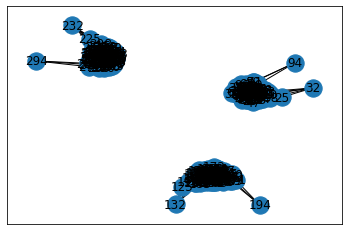

In [11]:
nx.draw_networkx(G) # check that I do have something

## Updating the weights

In [12]:
# the sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [13]:
# Setting Metropolis-Hastings weights
nnodes = G.number_of_nodes()
MHw = np.zeros((nnodes,nnodes)) # matrix of weights

# set off-diagonal elements (note that weights are symmetric)
for i, j in  G.edges():
    MHw[i, j] = 1/(np.max([G.degree(i),G.degree(j)])+1) # W[i,j] = W[j,i] = 1/(max(d(i),d(j))+1)
    MHw[j, i] = 1/(np.max([G.degree(i),G.degree(j)])+1)
    
#set diagonal elements
for i in G.nodes:
    MHw[i,i] = 1-np.sum(MHw[i,:]) # W[i,i] = 1 - sum_neighbors(W[i,j])

In [14]:
lamb=1/10 # the lambda
niter = 10 # the how many gradient descent iterations you want to run
nupdateg = 50 # how many times you want to update the gradients

# the NetworkX attributes are in a dictionary, which makes them annoying for matrix calculation
# that is why I am changing to numpy array here
tmp_w = np.vstack(list(nx.get_node_attributes(G,'w').values())) 
tmp_b = np.vstack(list(nx.get_node_attributes(G,'b').values()))

for i in range(niter):
    gradient_w = np.zeros((nnodes, nfeatures)) # array to store weight gradients
    gradient_b = np.zeros((nnodes,)) # array to store intercept gradients
    
    # get the gradients for each node
    for node in G.nodes():
        linear_part = np.dot(tmp_w[node,:], G.nodes[node]["x"]) + tmp_b[node] # the linear part inside the sigmoid
        pred = sigmoid(linear_part) # get predicted value
        error = pred - G.nodes[node]["y"] #get error
        gradient_w[node,:] = error * G.nodes[node]["x"]
        gradient_b[node] = error
    
    # don't know why you need to do this but update gradients for some iterations
    for n in range(nupdateg):
        gradient_w = np.dot(MHw, gradient_w)
        gradient_b = np.dot(MHw, gradient_b).reshape(-1,1)
    
    # update weights
    tmp_w -= lamb * gradient_w
    tmp_b -= lamb * gradient_b


In [15]:
# set the final weights and incercept
# print the weights of each node.
# additionally, create a list of values for colormap. Norm of the weight vector seems to work well
node_color = []
for node in G.nodes(): 
    G.nodes[node]['w'] =  tmp_w[node]
    G.nodes[node]['b'] = tmp_b[node]
    print("node {}: {}".format(node,G.nodes[node]['w']))
    node_color.append( np.linalg.norm(tmp_w[node]))

node 0: [-0.23469594 -0.00054513  0.00647552  0.00890055  0.00266389  0.00413673]
node 1: [-0.23476983 -0.0005496   0.00647931  0.0088951   0.00266511  0.00413988]
node 2: [-0.23485814 -0.00055493  0.00648373  0.00888859  0.00266654  0.00414368]
node 3: [-0.23474784 -0.00054828  0.00647826  0.00889672  0.00266477  0.00413892]
node 4: [-0.23481243 -0.00055213  0.00648095  0.008892    0.00266563  0.00414184]
node 5: [-0.23478319 -0.00055036  0.00647943  0.00889416  0.00266515  0.0041406 ]
node 6: [-0.23481243 -0.00055213  0.00648095  0.008892    0.00266563  0.00414184]
node 7: [-0.23486645 -0.00055535  0.00648308  0.00888806  0.00266631  0.00414432]
node 8: [-0.23477578 -0.00054996  0.00647958  0.00889466  0.0026652   0.00414014]
node 9: [-0.2330514  -0.00044399  0.00636886  0.0090236   0.00262922  0.00407255]
node 10: [-0.23483358 -0.00055343  0.00648229  0.00889042  0.00266607  0.00414268]
node 11: [-0.23483358 -0.00055343  0.00648229  0.00889042  0.00266607  0.00414268]
node 12: [-0.2

## Extra

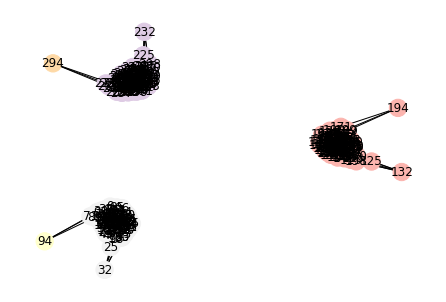

In [16]:
# drawing the graph
# while most nodes have many neighbors,
# 94, 194, and 294 have only 3 neighbors, and that's why 2 of them appear in different colors (the 2 had infection in the first place)
# 32, 132, and 232 have only 5 neighbors, but their weights seem to be the same as the other nodes in the group

cmap = matplotlib.cm.get_cmap("Pastel1")
nx.draw(G, with_labels=True, node_color=node_color, cmap=cmap)

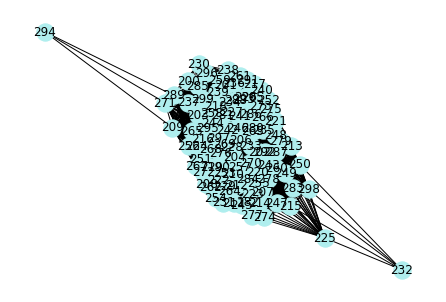

In [17]:
nx.draw(G.subgraph(range(200,300)), with_labels=True, node_color="paleturquoise")

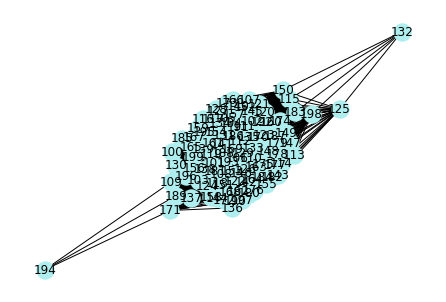

In [18]:
nx.draw(G.subgraph(range(100,200)), with_labels=True, node_color="paleturquoise")

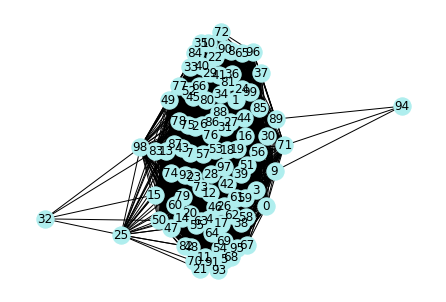

In [19]:
nx.draw(G.subgraph(range(0,100)), with_labels=True, node_color="paleturquoise")